In [16]:
'''
验证权重衰减的高纬线性回归实验,本实验是自己写loss function的复杂版本，本文件夹中的另一个
ipy文件是采用pytorch简洁实现
'''
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("..")
import dlzh.d2lzh_pytorch as d2l

In [17]:
'''
标签生成函数为 y=0.05+sum(0.01x_i)+noise
其中噪声项noise服从均值为0，标准差为0。01的正态分布
这里为了形成过拟合的情况，所以训练数据集变少设置为20
设置维度为200
'''
n_train,n_test,num_inputs=20,100,200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05
features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01,size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :],features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [18]:
'''1. 首先随机初始化模型参数'''
#定义随机初始化模型参数的函数，该函数为每个参数附上梯度
def init_params():
    w=torch.randn((num_inputs,1),requires_grad=True)
    b=torch.zeros(1,requires_grad=True)
    return [w,b]

In [19]:
'''2. 定义L2范数的惩罚项'''
#这里没有采用矩阵的乘法，因为矩阵的乘法该是多少行多少列实在是太麻烦了
def l2_penalty(w):
    return (w**2).sum()/2


In [32]:
'''3. 定义和训练模型'''
batch_size,num_enpochs,lr=1,100,0.003
net,loss=d2l.linreg,d2l.squared_loss

dataset=torch.utils.data.TensorDataset(train_features,train_labels)
train_iter=torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)

#训练模型,这里唯一的参数就是惩罚项的lamdb参数
def fit_and_plot(lambd):
    w,b=init_params()
    #用来记录训练误差和测试误差
    train_ls,test_ls=[],[]
    for _ in range(num_enpochs):
        for X,y in train_iter:
            y_pre=net(X,w,b)
            l=loss(y_pre,y)+lambd*l2_penalty(w)
            #这里求和是为了后面的反向传播方便，因为使用backward()函数最好是一个值而不是一个tensor
            l=l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w,b],lr,batch_size)
        train_ls.append(loss(net(train_features,w,b),train_labels).mean().item())
        test_ls.append(loss(net(test_features,w,b),test_labels).mean().item())
    d2l.semilogy(range(1, num_enpochs + 1), train_ls, 'epochs',
                 'loss',range(1, num_enpochs + 1), test_ls, ['train','test'])
    print('L2 norm of w:', w.norm().item())

L2 norm of w: 12.79116439819336


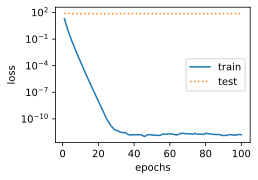

In [54]:
#当不设置lamda参数时
fit_and_plot(0)



L2 norm of w: 0.03595028445124626


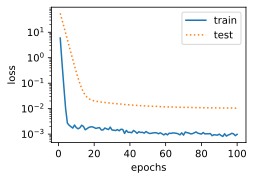

In [56]:
#将lamda参数设置为5的时候
fit_and_plot(5)

In [ ]:
def fit_and_plot_pytorch(wd):
# 对权重参数衰减
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr,weight_decay=wd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr) # 对偏置参数不衰减
    train_ls, test_ls = [], []
    for _ in range(num_enpochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            l.backward()
            #对俩优化函数实例进行调用step()函数来更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features),train_labels).mean().item())
        test_ls.append(loss(net(test_features),test_labels).mean().item())
    d2l.semilogy(range(1, num_enpochs + 1), train_ls, 'epochs',
    'loss',
    range(1, num_enpochs + 1), test_ls, ['train',
    'test'])
    print('L2 norm of w:', net.weight.data.norm().item())
